The goal here is to compare methods which fit data with psychometric curves using logistic regression. Indeed, after (long) experiments where for instance you collected sequences of keypresses, it is important to infer at best the parameters of the underlying processes: was the observer biased, was she more precise? While I was *forevever* using [sklearn](https://scikit-learn.org/stable/index.html) and praised it's beautifully crafted methods, I lacked some flexibility in the definition of the model. This notebook was done in collaboration with [Jenna Fradin](https://github.com/jennafradin), master student in the lab.

Here, I define a similar fitting method using [pytorch](https://pytorch.org/) which fits in a few lines of code :

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss(reduction='sum')

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-3): 
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))
        
    def forward(self, theta):
        p0 = self.logit0.sigmoid()
        out = p0/2 + (1-p0)*(self.linear(theta).sigmoid())
        return out

learning_rate = 0.02
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 512
#num_epochs = 128 # DEBUG
batch_size = 8

def fit_data(theta, y, 
                learning_rate=learning_rate,
                num_epochs=num_epochs,
                batch_size=batch_size, betas=betas,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader), betas=betas)
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item()/len(theta)
    return logistic_model, loss

and run a series of tests to compare both methods.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [2]:
from pylab import rcParams
#print(rcParams)

In [3]:
fontsize = 20
rcParams['font.size'] = fontsize
rcParams['legend.fontsize'] = fontsize
rcParams['axes.labelsize'] = fontsize
    
import numpy as np
import matplotlib.pyplot as plt

Some hyper parameters which we will tune later:

In [4]:
N = 200            
batch_size = N//4
#batch_size = N//2

N_cv = 10
# N_cv = 2

seed = 42
N_scan = 9
N_test = 2000 # number of points for validation

bias = True

p0 = 0.02         
theta0 = 0.
wt = np.pi/20      
theta_std = np.pi/6

## problem statement: a 2aFC task on synthetic data

We will generate a typical setup where we have to guess for the otientation of a visual display compared to the vertical and ask observer to either press on the `left` or `right` arrows. The visual display will be controlled by a $theta$ parameter which we draw randomly according to a Gaussian probability density function. This may be synthesized in the following function:


In [5]:
def psychometric_function(theta,
                            p0 = p0,
                            theta0 = theta0,
                            wt = wt,
                            ):
    return p0/2 + (1-p0) / (1+np.exp(-(theta-theta0)/wt))

In [6]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):    
    np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    
    p = psychometric_function(theta, p0, theta0, wt)

    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [7]:
%%timeit
theta, p, y = get_data()

The slowest run took 6.84 times longer than the fastest. This could mean that an intermediate result is being cached.
211 µs ± 93.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y,verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.65580
Iteration: 16 - Loss: 0.59306
Iteration: 32 - Loss: 0.54721
Iteration: 48 - Loss: 0.51284
Iteration: 64 - Loss: 0.48632
Iteration: 80 - Loss: 0.46525
Iteration: 96 - Loss: 0.44787
Iteration: 112 - Loss: 0.43315
Iteration: 128 - Loss: 0.42058
Iteration: 144 - Loss: 0.40961
Iteration: 160 - Loss: 0.40015
Iteration: 176 - Loss: 0.39187
Iteration: 192 - Loss: 0.38467
Iteration: 208 - Loss: 0.37840
Iteration: 224 - Loss: 0.37299
Iteration: 240 - Loss: 0.36821
Iteration: 256 - Loss: 0.36419
Iteration: 272 - Loss: 0.36067
Iteration: 288 - Loss: 0.35761
Iteration: 304 - Loss: 0.35497
Iteration: 320 - Loss: 0.35269
Iteration: 336 - Loss: 0.35074
Iteration: 352 - Loss: 0.34907
Iteration: 368 - Loss: 0.34765
Iteration: 384 - Loss: 0.34645
Iteration: 400 - Loss: 0.34537
Iteration: 416 - Loss: 0.34447
Iteration: 432 - Loss: 0.34369
Iteration: 448 - Loss: 0.34301
Iteration: 464 - Loss: 0.34242
Iteration: 480 - Loss: 0.34193
Iteration: 496 - Loss: 0.34149
Final loss = 0.3

In [9]:
print(f'p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}')

p0 = 0.020, theta0 = 0.000, wt = 0.157, theta_std = 0.524


In [10]:
def get_params(logistic_model, verbose=False):
    theta0_ = -logistic_model.linear.bias.item()/logistic_model.linear.weight.item()
    wt_ = 1/logistic_model.linear.weight.item()
    p0_ = torch.sigmoid(logistic_model.logit0).item()
    if verbose:
        if bias: print(f'theta0 = {theta0_:.3f}' )
        print(f'slope = {wt_:.3f}')    
        print(f'p0 = {p0_:.3f}')        
    return theta0_, wt_, p0_

theta0_, wt_, p0_ = get_params(logistic_model, verbose=True)

theta0 = 0.006
slope = 0.168
p0 = 0.002


That method is fairly quick, in under 2 seconds:

In [11]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

14.6 s ± 3.81 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


let's do the same thing with `sklearn`: 

In [12]:
from sklearn.linear_model import LogisticRegression
tol = 1.e-4
C = 3.0
def fit_data_sklearn(theta, y, 
                num_epochs=num_epochs,
                tol=tol, C=C, 
                verbose=False):
    logistic_model = LogisticRegression(solver='liblinear', max_iter=num_epochs, C=C, tol=tol, fit_intercept=True)
    logistic_model.fit(theta[:, None], y)
    
    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    loss = criterion(outputs_, labels).item()/len(theta)
    if verbose: print("Loss =", loss)
    return logistic_model, loss

In [13]:
logistic_model_sk, loss = fit_data_sklearn(theta, y, verbose=True) 

Loss = 0.34461827952674307


In [14]:
def get_params_sk(logistic_model, verbose=False):
    
    theta0_ = -logistic_model.intercept_[0]/logistic_model.coef_[0][0]
    wt_ = 1/logistic_model.coef_[0][0]

    if verbose:
        if bias: print(f'theta0 = {theta0_:.3f}' )
        print(f'slope = {wt_:.3f}')    
    return theta0_, wt_

theta0_, wt_ = get_params_sk(logistic_model_sk, verbose=True)

theta0 = 0.006
slope = 0.183


That method is *much* quicker:

In [15]:
%%timeit
logistic_model_sk, loss = fit_data_sklearn(theta, y, verbose=False)

1.5 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


... but what is the value of few seconds after hours of having observers sitting in front of a screen looking at (often boring) visual displays? More seriously, most important is the reliability of the values which are inferred by each respective method, such that they are correctly reflecting the information contained in the data.

## qualitative comparison of methods

We can synthesize this comparison by drawing a new dataset and plotting the psychometric curves which are obtained by each method

In [16]:
theta, p, y = get_data() # nouvelles données 
logistic_model, loss = fit_data(theta, y, verbose=False)
print(f'Training loss = {loss:.3f}')
logistic_model_sk, loss_sk = fit_data_sklearn(theta, y, verbose=False)
print(f'Training sklearn loss = {loss_sk:.3f}')

Training loss = 0.342
Training sklearn loss = 0.345


ValueError: x and y must have same first dimension, but have shapes (100, 1) and (200,)

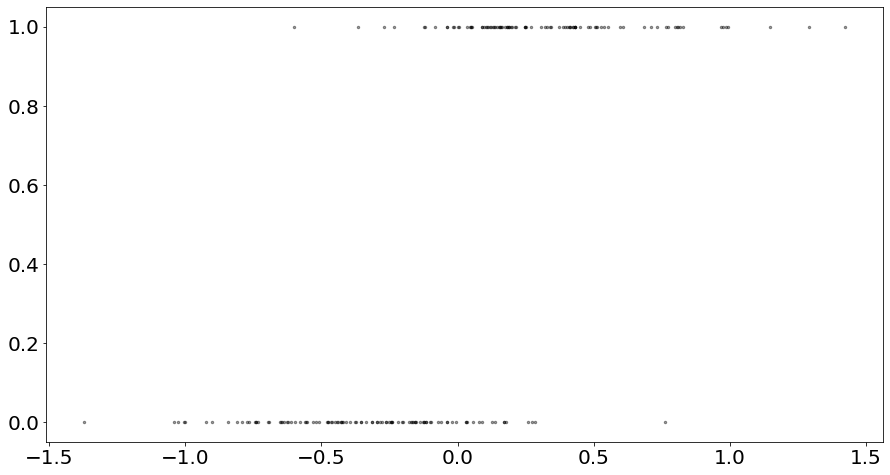

In [17]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(theta, y, s=6, alpha=.4, color = 'k', label='data points')
# ax.scatter(theta, p, s=6, alpha=.4, color = 'b', label='hidden proba')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values_p = psychometric_function(theta, p0, theta0, wt)
ax.plot(x_values, y_values_p, alpha=.4, color = 'b', label='hidden proba')
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
ax.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='torch')
y_values_sk = logistic_model_sk.predict_proba(x_values)[:, 1]
ax.plot(x_values, y_values_sk, 'r', alpha=.7, lw=3, label='sklearn')
ax.set_xlabel(r'orientation $\theta$', fontsize=20)
ax.set_yticks([0.,1.])
ax.set_yticklabels(['Left', 'Right'], fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

The losses which were computed above are those obtained during training. Relying on this value may be a dangerous strategy as the model may be overfitting the data. We should therefore measure how the model would generalize with novel data.

While it hard to do with real (experimental) data which are often scarse, here we synthesized the data and we can thus compute a testing loss by drawing again a set of new data and computing the loss on that data:

In [ ]:
theta, p, y = get_data(N=N_test, seed=seed)    

In [ ]:
def loss_true(theta, p, y):
    # p0=p0, theta0=theta0, wt=wt, 
    # p = p0/2 + (1-p0) / (1+np.exp(-(theta-theta0)/wt))

    labels = torch.Tensor(y[:, None])        
    P = torch.Tensor(p[:, None])
    return criterion(P, labels).item()/len(theta)
print(f'Testing true loss = {loss_true(theta, p, y):.3f}')

In [ ]:
logistic_model, loss = fit_data(theta, y, verbose=False)
print(f'Training loss = {loss:.3f}')

In [ ]:
def loss_torch(logistic_model, theta, p, y):
    theta, p, y = get_data(N=N_test, seed=seed)
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    P = torch.Tensor(p[:, None])

    outputs = logistic_model(Theta)
    return criterion(outputs, labels).item()/len(theta)
print(f'Testing loss = {loss_torch(logistic_model, theta, p, y):.3f}')

In [ ]:
logistic_model_sk, loss_sk = fit_data_sklearn(theta, y, verbose=False)
print(f'Training sklearn loss = {loss_sk:.3f}')

In [ ]:
def loss_sklearn(logistic_model, theta, p, y):
    theta, p, y = get_data(N=N_test, seed=seed)
    
    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    return criterion(outputs_, labels).item()/len(theta)

print(f'Testing sklearn loss = {loss_sklearn(logistic_model_sk, theta, p, y):.3f}')


## quantitative comparison of methods : varrying methods' parameters

Let's study the influence of each method's meta-parameter, such as the number of iterations:

### influence of learning rate


In [ ]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps = [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)        

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
        loss_P = loss_true(theta, p, y)
        
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        learning_rates_.append(learning_rate_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

In [ ]:
opts = dict(marker='.', lw=0, alpha=3/N_cv, ms=20)

In [ ]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8))
ax.plot(learning_rates_, losses, **opts, color='green', label='loss')
ax.plot(learning_rates_, loss_Ps, **opts, color='blue', label='true')

ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.legend(loc='best');

### influence du nombre d'epochs

In [ ]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_SKLs = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)
                
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        num_epochss_.append(num_epochs_)
        loss_SKLs.append(loss_SKL/loss_P)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

In [ ]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(num_epochss_, losses, **opts, color='green', label='loss')
ax.plot(num_epochss_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(num_epochss_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('# epochs')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of minibatch size

In [ ]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps = [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
        loss_P = loss_true(theta, p, y)
        
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        batch_sizes_.append(batch_size_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

In [ ]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(batch_sizes_, losses, **opts, color='green', label='loss')
ax.plot(batch_sizes_, loss_Ps, **opts, color='blue', label='true')

ax.set_xlabel('batch_size')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `beta1`

In [ ]:
beta1s = 1. - np.logspace(-3, -1, N_scan, base=10, endpoint=True)
beta1s_, losses, loss_Ps = [], [], []
for beta1_ in beta1s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, betas=(beta1_, beta2), verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
        loss_P = loss_true(theta, p, y)

        if i_CV==0: 
            print(f"beta1: {beta1_}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        beta1s_.append(beta1_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(beta1s_, losses, **opts, color='green', label='loss')
ax.plot(beta1s_, loss_Ps, **opts, color='blue', label='true')

ax.set_xlabel('beta1')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `beta2`

In [ ]:
beta2s = 1. - np.logspace(-3, -1, N_scan, base=10, endpoint=True)
beta2s_, losses, loss_Ps = [], [], []
for beta2_ in beta2s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model, loss = fit_data(theta, y, betas=(beta1, beta2_), verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
        loss_P = loss_true(theta, p, y)
        
        if i_CV==0: 
            print(f"beta2: {beta2_}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}")
        beta2s_.append(beta2_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(beta2s_, losses, **opts, color='green', label='loss')
ax.plot(beta2s_, loss_Ps, **opts, color='blue', label='true')

ax.set_xlabel('beta1')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `C`

In [ ]:
Cs = C * np.logspace(-2, 2, N_scan, base=4)
Cs_, loss_Ps, loss_SKLs = [], [], []
for C_ in Cs:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, C=C_, verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV==0: 
            print(f"C: {C_}, Loss: {loss:.5f}, loss_SKL: {loss_SKL:.5f}")
            
        Cs_.append(C_)
        loss_SKLs.append(loss_SKL/loss_P)
        loss_Ps.append(loss_P/loss_P)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(Cs_, loss_Ps, **opts, color='blue', label='true')
ax.plot(Cs_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('C')
ax.set_ylabel('Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

### influence of `tol`

In [ ]:
tols = tol * np.logspace(-2, 2, N_scan, base=10)
tols_, loss_Ps, loss_SKLs = [], [], []
for tol_ in tols:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)

        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, tol=tol_, verbose=False)
        
        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV==0: 
            print(f"tol: {tol_}, Loss: {loss:.5f}, loss_SKL: {loss_SKL:.5f}")
        tols_.append(tol_)
        loss_SKLs.append(loss_SKL/loss_P)
        loss_Ps.append(loss_P/loss_P)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(tols_, loss_Ps, **opts, color='blue', label='true')
ax.plot(tols_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel('tol')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.legend(loc='best');


## quantitative comparison of methods : varrying experimental parameters


### influence of number of trials

In [ ]:
Ns = np.logspace(1, 3, N_scan, base=10, endpoint=True)

Ns_, losses, loss_Ps, loss_SKLs = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        if N_test>0:
            theta, p, y = get_data(N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        loss_SKLs.append(loss_SKL/loss_P)
        Ns_.append(N_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)
    

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(Ns_, losses, **opts, color='green', label='loss')
ax.plot(Ns_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(Ns_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel(' # trials')
ax.set_ylabel('Loss')
ax.set_xscale('log')
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

### influence of number of theta_std


The convergence of the fitting procedure may also depend on the parametrers of the data which were set to:

In [ ]:
print(f'p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}')

In [ ]:
theta_stds = theta_std * np.logspace(-1, 1, N_scan, base=2, endpoint=True)

theta_stds_, losses, loss_Ps, loss_SKLs = [], [], [], []

for theta_std_ in theta_stds:
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta_std=theta_std_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        if N_test>0:
            theta, p, y = get_data(theta_std=theta_std_, N=N_test, seed=seed+i_CV+N_test)
            loss = loss_torch(logistic_model, theta, p, y)            
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)

        if i_CV==0: print(f"theta_std: {theta_std_:.3f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        loss_SKLs.append(loss_SKL/loss_P)
        theta_stds_.append(theta_std_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)
    

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(theta_stds_, losses, **opts, color='green', label='loss')
ax.plot(theta_stds_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(theta_stds_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel(' # trials')
ax.set_ylabel('Loss')
ax.set_xscale('log')
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

### influence of number of `p0`



In [ ]:
p0s = np.logspace(-3, -.7, N_scan, base=10, endpoint=True)

p0s_, losses, loss_Ps, loss_SKLs = [], [], [], []

for p0_ in p0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)
        
        if N_test>0:
            theta, p, y = get_data(p0=p0_, N=N_test, seed=seed+i_CV)
            loss = loss_torch(logistic_model, theta, p, y)
            loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)
        loss_P = loss_true(theta, p, y)
        
        if i_CV==0: print(f"theta_std: {theta_std_:.3f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_SKL: {loss_SKL:.5f}")
        loss_SKLs.append(loss_SKL/loss_P)
        p0s_.append(p0_)
        loss_Ps.append(loss_P/loss_P)
        losses.append(loss/loss_P)
    

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(theta_stds_, losses, **opts, color='green', label='loss')
ax.plot(theta_stds_, loss_Ps, **opts, color='blue', label='loss_P')
ax.plot(theta_stds_, loss_SKLs, **opts, color='red', label='loss_SKL')

ax.set_xlabel(' # trials')
ax.set_ylabel('Loss')
ax.set_xscale('log')
plt.legend(fontsize=20, frameon=False, scatterpoints=6);



## comparing the predicted values


In [ ]:
print(f'p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}')



### changing `p0`


In [ ]:
N_scan = 20
p0s = np.logspace(-3, -.7, N_scan, base=10, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = [], [], [], [], [], [], [], []

for p0_ in p0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)
        
        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)
        
        p0s_.append(p0_)
        theta0s_.append(theta0)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)
    

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(p0s_, p0_tos, label='torch')
axs[0].plot([min(p0s_), max(p0s_)], [min(p0_tos), max(p0_tos)], '--')
axs[0].set(xlabel='p0 (true)', ylabel='p0 (predicted)')
axs[0].legend(loc="upper left")

axs[1].scatter(theta0s_, theta0_tos, label='torch')
axs[1].scatter(theta0s_, theta0_sks, label='sklearn')
axs[1].plot([min(theta0s_), max(theta0s_)], [min(theta0_sks), max(theta0_sks)], '--')
axs[1].set(xlabel='theta0 (true)', ylabel='theta0 (predicted)')
axs[1].legend(loc="upper left")

axs[2].scatter(wts_, wt_tos, label='torch')
axs[2].scatter(wts_, wt_sks, label='sklearn')
axs[2].plot([min(wts_), max(wts_)], [min(wts_), max(wts_)], '--')
axs[2].set(xlabel='slope (true)', ylabel='slope (predicted)')
axs[2].legend(loc="upper left")
plt.tight_layout();



### changing `theta0`


In [ ]:
N_scan = 20
theta0s = theta_std * np.linspace(-1, 1, N_scan, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = [], [], [], [], [], [], [], []

for theta0_ in theta0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta0=theta0_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)
        
        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)
        
        p0s_.append(p0)
        theta0s_.append(theta0_)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)
    

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(p0s_, p0_tos, label='torch')
axs[0].plot([min(p0s_), max(p0s_)], [min(p0_tos), max(p0_tos)], '--')
axs[0].set(xlabel='p0 (true)', ylabel='p0 (predicted)')
axs[0].legend(loc="upper left")

axs[1].scatter(theta0s_, theta0_tos, label='torch')
axs[1].scatter(theta0s_, theta0_sks, label='sklearn')
axs[1].plot([min(theta0s_), max(theta0s_)], [min(theta0_sks), max(theta0_sks)], '--')
axs[1].set(xlabel='theta0 (true)', ylabel='theta0 (predicted)')
axs[1].legend(loc="upper left")

axs[2].scatter(wts_, wt_tos, label='torch')
axs[2].scatter(wts_, wt_sks, label='sklearn')
axs[2].plot([min(wts_), max(wts_)], [min(wts_), max(wts_)], '--')
axs[2].set(xlabel='slope (true)', ylabel='slope (predicted)')
axs[2].legend(loc="upper left")
plt.tight_layout();



### changing `wt`


In [ ]:
N_scan = 20
wts = wt * np.logspace(-1, 1, N_scan, base=10, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = [], [], [], [], [], [], [], []

for wt_ in wts:
    for i_CV in range(N_cv):
        theta, p, y = get_data(wt=wt_, seed=seed+i_CV)
        
        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)
        
        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)
        
        p0s_.append(p0)
        theta0s_.append(theta0)
        wts_.append(wt_)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)
    

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(p0s_, p0_tos, label='torch')
axs[0].plot([min(p0s_), max(p0s_)], [min(p0_tos), max(p0_tos)], '--')
axs[0].set(xlabel='p0 (true)', ylabel='p0 (predicted)')
axs[0].legend(loc="upper left")

axs[1].scatter(theta0s_, theta0_tos, label='torch')
axs[1].scatter(theta0s_, theta0_sks, label='sklearn')
axs[1].plot([min(theta0s_), max(theta0s_)], [min(theta0_sks), max(theta0_sks)], '--')
axs[1].set(xlabel='theta0 (true)', ylabel='theta0 (predicted)')
axs[1].legend(loc="upper left")

axs[2].scatter(wts_, wt_tos, label='torch')
axs[2].scatter(wts_, wt_sks, label='sklearn')
axs[2].plot([min(wts_), max(wts_)], [min(wts_), max(wts_)], '--')
axs[2].set(xlabel='slope (true)', ylabel='slope (predicted)')
axs[2].legend(loc="upper left")
plt.tight_layout();